In [ ]:

from abc import ABC, abstractmethod
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, LSTM, Flatten
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
import numpy as np

class NeuralNet(ABC):
    MAX_EPOCHS = 1000
    BATCH_SIZE = 128
    LOSS = 'mean_absolute_error'
    METRICS = [ 'mean_squared_error']
    LEARNING_RATE = 0.1
    ACTIVATION = 'sigmoid'
    NNEURONS = [8]

    def __init__(self, **kwargs):
        self.batch_size = kwargs.get('batch_size', NeuralNet.BATCH_SIZE)
        self.loss = kwargs.get('loss', NeuralNet.LOSS)
        self.metrics = kwargs.get('metrics', NeuralNet.METRICS)
        self.max_epochs = kwargs.get('metrics', NeuralNet.MAX_EPOCHS)
        self.learning_rate = kwargs.get('learning_rate', NeuralNet.LEARNING_RATE)
        self.activation = kwargs.get('activation', NeuralNet.ACTIVATION)
        self.nneurons = kwargs.get('nneurons', NeuralNet.NNEURONS[:])

        self.model = Sequential()


    @abstractmethod
    def build_model(self):
        pass

    def train_model_with_valid(self, data_train_x, data_train_y, data_val_x, data_val_y):
        opt = Adam(learning_rate=self.learning_rate)

        self.model.compile(
            loss = self.loss,
            optimizer = opt,
            metrics =  self.metrics
        )

        earlystopping = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=100, verbose=0, mode='min', restore_best_weights=True)

        self.model.fit(
            data_train_x, data_train_y,
            verbose=0,
            shuffle=True,
            batch_size=self.batch_size,
            epochs=self.max_epochs,
            validation_data=(data_val_x, data_val_y),
            callbacks=[earlystopping]
        )

        hist = self.model.history.history['val_loss']
        n_epochs_best = np.argmin(hist)
        scores_validation = self.model.evaluate(data_val_x, data_val_y, verbose=0, batch_size=data_val_x.shape[0])

        return (n_epochs_best, scores_validation[0])

    def train_model(self, data_x, data_y, opt_epochs):
        opt = Adam(learning_rate=self.learning_rate)
        self.model.compile(
            loss = self.loss,
            optimizer = opt,
            metrics =  self.metrics
        )
        print("compiled")
        self.model.fit(
            data_x, data_y,
            shuffle=True,
            batch_size=self.batch_size,
            epochs=int(opt_epochs),
            validation_split = 0.0
        )

    def predict(self, data_x):
        return self.model.predict(data_x, batch_size = data_x.shape[0])

class MLP(NeuralNet):
    def __init__(self,use_gpu=True, **kwargs):
        super().__init__(**kwargs)
        self.use_gpu = use_gpu

    def build_model(self, input_shape):
        self.model = Sequential()
        self.model.add(Flatten(input_shape=input_shape))
        for nn in self.nneurons:
            self.model.add(Dense(nn, activation=self.activation))
        self.model.add(Dense(1, activation='linear'))
class LSTMc(NeuralNet):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def build_model(self, input_shape):
        self.model = Sequential()
        if len(self.nneurons) == 1:
            self.model.add(LSTM(self.nneurons[0], input_shape = input_shape, activation=self.activation))
        else:
            self.model.add(LSTM(self.nneurons[0], input_shape = input_shape, activation=self.activation, return_sequences=True))
            for nn in self.nneurons[1:-1]:
                self.model.add(LSTM(nn, activation=self.activation, return_sequences=True))
            self.model.add(LSTM(self.nneurons[-1], activation=self.activation))

        self.model.add(Dense(self.nneurons[-1], activation = self.activation))
        self.model.add(Dense(1, activation = 'linear'))

        #self.random_weights = self.model.get_weights() # save random weights to re-initialize the model in new runs
class ArbitraryNN(NeuralNet):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def build_model(self, input_shape):
        self.model = Sequential()
        self.model.add(LSTM(8, input_shape = input_shape, activation = 'tanh', return_sequences=True))
        self.model.add(Dropout(0.1))
        self.model.add(BatchNormalization())
        self.model.add(LSTM(8, activation = 'tanh'))
        self.model.add(Dropout(0.1))
        self.model.add(BatchNormalization())
        self.model.add(Dense(8, activation = 'sigmoid'))
        self.model.add(Dense(1, activation = 'linear'))

        #self.random_weights = self.model.get_weights() # save random weights to re-initialize the model in new runs


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from google.colab import drive
drive.mount('/content/drive')
df = pd.read_csv("/content/drive/MyDrive/Vig/Historical weahe.csv")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df.set_index('time', inplace=True)
X = df.drop(columns=['shortwave_radiation (W/m²)'])
y = df['shortwave_radiation (W/m²)']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.125, random_state=42)


In [ ]:
mlp = MLP(nneurons=[32, 32], activation="relu")
mlp.build_model((1,18))
print(X_train.shape)

(480412, 18)


In [ ]:
X_train_reshaped = np.expand_dims(X_train.values, axis=1)
print(X_train_reshaped.shape)

(480412, 1, 18)


In [ ]:
mlp.train_model(X_train_reshaped, y_train.values, 50)

compiled
Epoch 1/50
3754/3754 [==============================] - 20s 3ms/step - loss: 9.7308 - mean_squared_error: 1259.3289
Epoch 2/50
3754/3754 [==============================] - 12s 3ms/step - loss: 8.6344 - mean_squared_error: 308.5759
Epoch 3/50
3754/3754 [==============================] - 12s 3ms/step - loss: 8.4762 - mean_squared_error: 302.0716
Epoch 4/50
3754/3754 [==============================] - 12s 3ms/step - loss: 9.0202 - mean_squared_error: 358.6402
Epoch 5/50
3754/3754 [==============================] - 12s 3ms/step - loss: 10.6008 - mean_squared_error: 473.0415
Epoch 6/50
3754/3754 [==============================] - 12s 3ms/step - loss: 12.1924 - mean_squared_error: 600.3099
Epoch 7/50
3754/3754 [==============================] - 13s 3ms/step - loss: 13.8934 - mean_squared_error: 816.1495
Epoch 8/50
3754/3754 [==============================] - 12s 3ms/step - loss: 14.8429 - mean_squared_error: 921.1338
Epoch 9/50
3754/3754 [==============================] - 12s 3ms/st

In [ ]:
X_test_reshaped = np.expand_dims(X_test.values, axis=1)
print(X_test_reshaped.shape)

(137261, 1, 18)


In [ ]:
predictions_test = mlp.predict(X_test_reshaped)

1/1 [==============================] - 0s 97ms/step


In [ ]:
print(predictions_test.shape)

(137261, 1)


In [ ]:
print(y_test.shape)

(137261,)


1/1 [==============================] - 0s 26ms/step


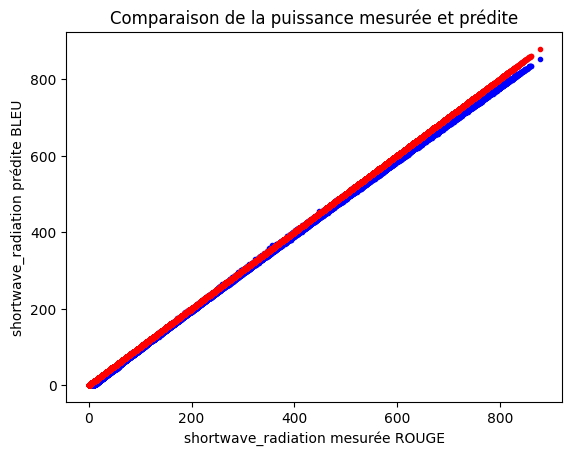

In [ ]:
import matplotlib.pyplot as plt
predictions_test = mlp.predict(X_test_reshaped)
plt.scatter(y_test, predictions_test, c='b', marker='.', label='Mesuré')
plt.scatter(y_test, y_test, c='r', marker='.', label='Prédit')
plt.xlabel("shortwave_radiation mesurée ROUGE")
plt.ylabel("shortwave_radiation prédite BLEU")
plt.title("Comparaison de la puissance mesurée et prédite")
plt.show()


In [ ]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
mse = mean_squared_error(y_test, predictions_test)
mae = mean_absolute_error(y_test, predictions_test)
print("Mean Absolute Error (MAE): ", mae)
# afficher le résultat
print("Mean Squared Error (MSE) :", mse)

Mean Absolute Error (MAE):  3.2381504674212485
Mean Squared Error (MSE) : 27.995598764217227


In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Calcul des différentes métriques d'évaluation
mse = mean_squared_error(y_test, predictions_test)
mae = mean_absolute_error(y_test, predictions_test)
rmse = np.sqrt(mse)
nmae = mae / np.mean(y_test)
nrmse = rmse / np.mean(y_test)

# Affichage des métriques sous forme de tableau
print('| Métrique | Valeur |')
print('| --- | --- |')
print('| MSE | {:.3f} |'.format(mse))
print('| MAE | {:.3f} |'.format(mae))
print('| RMSE | {:.3f} |'.format(rmse))
print('| nMAE | {:.3f} |'.format(nmae))
print('| nRMSE | {:.3f} |'.format(nrmse))


| Métrique | Valeur |
| --- | --- |
| MSE | 27.996 |
| MAE | 3.238 |
| RMSE | 5.291 |
| nMAE | 0.027 |
| nRMSE | 0.044 |


In [ ]:
lstmc = LSTMc(nneurons=[16], activation="relu")
lstmc.build_model((1,18))
print(X_train.shape)

(480412, 18)


In [ ]:
X_train_reshaped = np.expand_dims(X_train.values, axis=1)
print(X_train_reshaped.shape)

(480412, 1, 18)


In [ ]:
lstmc.train_model(X_train_reshaped, y_train.values, 50)

compiled
Epoch 1/50
3754/3754 [==============================] - 26s 6ms/step - loss: 8.4792 - mean_squared_error: 529.6275
Epoch 2/50
3754/3754 [==============================] - 24s 6ms/step - loss: 7.8876 - mean_squared_error: 252.5985
Epoch 3/50
3754/3754 [==============================] - 24s 6ms/step - loss: 7.1341 - mean_squared_error: 214.4392
Epoch 4/50
3754/3754 [==============================] - 24s 6ms/step - loss: 7.5444 - mean_squared_error: 232.4021
Epoch 5/50
3754/3754 [==============================] - 24s 7ms/step - loss: 7.7131 - mean_squared_error: 247.2347
Epoch 6/50
3754/3754 [==============================] - 24s 6ms/step - loss: 7.4226 - mean_squared_error: 227.7480
Epoch 7/50
3754/3754 [==============================] - 22s 6ms/step - loss: 7.4037 - mean_squared_error: 224.7157
Epoch 8/50
3754/3754 [==============================] - 24s 6ms/step - loss: 7.7906 - mean_squared_error: 253.0936
Epoch 9/50
3754/3754 [==============================] - 25s 7ms/step - 

In [ ]:
X_test_reshaped = np.expand_dims(X_test.values, axis=1)
print(X_test_reshaped.shape)

(137261, 1, 18)


In [ ]:
predictions_test = lstmc.predict(X_test_reshaped)

1/1 [==============================] - 0s 170ms/step


In [ ]:
print(predictions_test.shape)

(137261, 1)


In [ ]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
mse = mean_squared_error(y_test, predictions_test)
mae = mean_absolute_error(y_test, predictions_test)
print("Mean Absolute Error (MAE): ", mae)
# afficher le résultat
print("Mean Squared Error (MSE) :", mse)

Mean Absolute Error (MAE):  9.721366953308083
Mean Squared Error (MSE) : 297.61027887124254


In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Calcul des différentes métriques d'évaluation
mse = mean_squared_error(y_test, predictions_test)
mae = mean_absolute_error(y_test, predictions_test)
rmse = np.sqrt(mse)
nmae = mae / np.mean(y_test)
nrmse = rmse / np.mean(y_test)

# Affichage des métriques sous forme de tableau
print('| Métrique | Valeur |')
print('| --- | --- |')
print('| MSE | {:.3f} |'.format(mse))
print('| MAE | {:.3f} |'.format(mae))
print('| RMSE | {:.3f} |'.format(rmse))
print('| nMAE | {:.3f} |'.format(nmae))
print('| nRMSE | {:.3f} |'.format(nrmse))

| Métrique | Valeur |
| --- | --- |
| MSE | 297.610 |
| MAE | 9.721 |
| RMSE | 17.251 |
| nMAE | 0.081 |
| nRMSE | 0.144 |


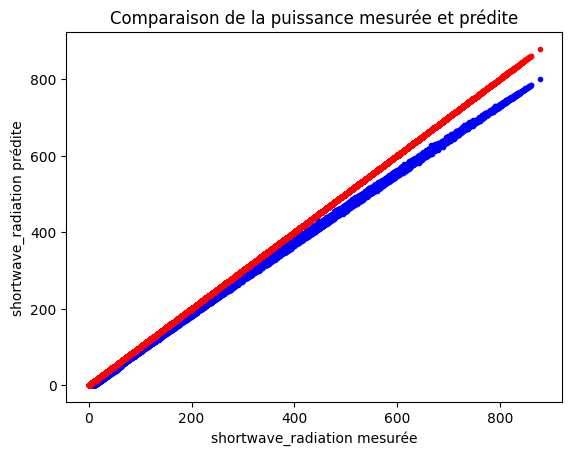

In [ ]:
import matplotlib.pyplot as plt

plt.scatter(y_test, predictions_test, c='b', marker='.', label='Mesuré')
plt.scatter(y_test, y_test, c='r', marker='.', label='Prédit')
plt.xlabel("shortwave_radiation mesurée")
plt.ylabel("shortwave_radiation prédite")
plt.title("Comparaison de la puissance mesurée et prédite")
plt.show()


In [ ]:
arb = ArbitraryNN(nneurons=[16,16], activation="relu")
arb.build_model((1,18))
print(X_train.shape)

(480412, 18)


In [ ]:
X_train_reshaped = np.expand_dims(X_train.values, axis=1)
print(X_train_reshaped.shape)

(480412, 1, 18)


In [ ]:
arb.train_model(X_train_reshaped, y_train.values, 50)

compiled
Epoch 1/50
3754/3754 [==============================] - 35s 8ms/step - loss: 119.0479 - mean_squared_error: 47679.7070
Epoch 2/50
3754/3754 [==============================] - 29s 8ms/step - loss: 119.0444 - mean_squared_error: 47692.3633
Epoch 3/50
3754/3754 [==============================] - 28s 8ms/step - loss: 119.0447 - mean_squared_error: 47681.0469
Epoch 4/50
3754/3754 [==============================] - 30s 8ms/step - loss: 119.0462 - mean_squared_error: 47682.5195
Epoch 5/50
3754/3754 [==============================] - 29s 8ms/step - loss: 119.0453 - mean_squared_error: 47682.3320
Epoch 6/50
3754/3754 [==============================] - 29s 8ms/step - loss: 119.0457 - mean_squared_error: 47699.7422
Epoch 7/50
3754/3754 [==============================] - 29s 8ms/step - loss: 119.0460 - mean_squared_error: 47674.8477
Epoch 8/50
3754/3754 [==============================] - 29s 8ms/step - loss: 119.0454 - mean_squared_error: 47678.9727
Epoch 9/50
3754/3754 [=================

In [ ]:
X_test_reshaped = np.expand_dims(X_test.values, axis=1)
print(X_test_reshaped.shape)

(137261, 1, 18)


In [ ]:
predictions_test = arb.predict(X_test_reshaped)

1/1 [==============================] - 1s 684ms/step


In [ ]:
print(predictions_test.shape)

(137261, 1)


In [ ]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
mse = mean_squared_error(y_test, predictions_test)
mae = mean_absolute_error(y_test, predictions_test)
print("Mean Absolute Error (MAE): ", mae)
# afficher le résultat
print("Mean Squared Error (MSE) :", mse)

Mean Absolute Error (MAE):  119.60584292798906
Mean Squared Error (MSE) : 48170.45767821777


In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Calcul des différentes métriques d'évaluation
mse = mean_squared_error(y_test, predictions_test)
mae = mean_absolute_error(y_test, predictions_test)
rmse = np.sqrt(mse)
nmae = mae / np.mean(y_test)
nrmse = rmse / np.mean(y_test)

# Affichage des métriques sous forme de tableau
print('| Métrique | Valeur |')
print('| --- | --- |')
print('| MSE | {:.3f} |'.format(mse))
print('| MAE | {:.3f} |'.format(mae))
print('| RMSE | {:.3f} |'.format(rmse))
print('| nMAE | {:.3f} |'.format(nmae))
print('| nRMSE | {:.3f} |'.format(nrmse))

| Métrique | Valeur |
| --- | --- |
| MSE | 48170.458 |
| MAE | 119.606 |
| RMSE | 219.478 |
| nMAE | 0.999 |
| nRMSE | 1.833 |


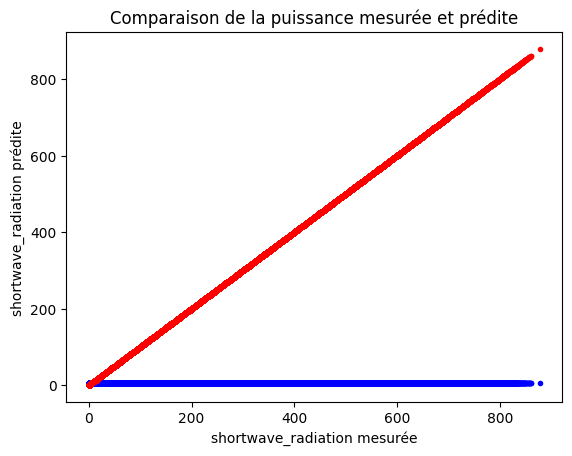

In [ ]:
import matplotlib.pyplot as plt

plt.scatter(y_test, predictions_test, c='b', marker='.', label='Mesuré')
plt.scatter(y_test, y_test, c='r', marker='.', label='Prédit')
plt.xlabel("shortwave_radiation mesurée")
plt.ylabel("shortwave_radiation prédite")
plt.title("Comparaison de la puissance mesurée et prédite")
plt.show()
